In [1]:
import gpxpy
import mplleaflet
import pandas as pd
import numpy as np
from pykalman import KalmanFilter

import matplotlib.pyplot as plt
#plt.rcParams['axes.xmargin'] = 0.1
#plt.rcParams['axes.ymargin'] = 0.1
%matplotlib inline

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("talk")

from gps_utils import haversine

%load_ext autoreload
%autoreload 2

In [2]:
from kalman_steps import *

In [3]:
gpx_obj, segment = step_01_load_data()

/home/dg/GitHubUbuntU/gps_data_with_python/gpx/3-laender-giro.gpx
/home/dg/GitHubUbuntU/gps_data_with_python/gpx/3-laender-giro_cleaned.gpx
/home/dg/GitHubUbuntU/gps_data_with_python/gpx/activity_11212422262.gpx
/home/dg/GitHubUbuntU/gps_data_with_python/gpx/hh_marathon.gpx


### Let's try to correct some unrealistic things like

In [4]:
segment.get_uphill_downhill()

UphillDownhill(uphill=231.82000389099125, downhill=232.42000999450704)

### ... and speed records on a bikecycle

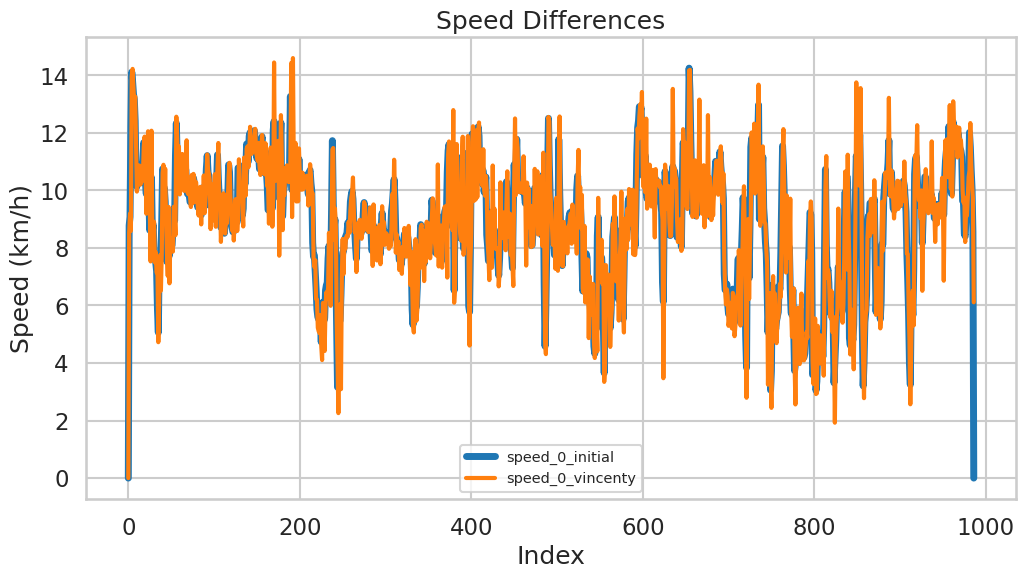

In [5]:
speed_dict = {}
step_02_initial_speed(gpx_obj, segment, speed_dict)
plot_all_keys(speed_dict)

### But we start with a little bit of data wrangling

In [6]:
coords = step_03_segments_to_coords_pd(segment)
print(coords.head())
print(coords.tail())

                           idx        lat        lon         ele     speed
time                                                                      
2023-05-28 03:34:21+00:00    0  41.138656  29.028546  109.800003  0.000000
2023-05-28 03:34:27+00:00    1  41.138534  29.028598  109.400002  2.439495
2023-05-28 03:34:30+00:00    2  41.138471  29.028636  108.800003  2.522874
2023-05-28 03:34:31+00:00    3  41.138453  29.028650  108.800003  3.398323
2023-05-28 03:34:33+00:00    4  41.138388  29.028685  108.199997  3.920986
                           idx        lat        lon         ele     speed
time                                                                      
2023-05-28 04:34:09+00:00  982  41.138998  29.029168  111.199997  3.195113
2023-05-28 04:34:15+00:00  983  41.138993  29.028951  110.000000  2.974100
2023-05-28 04:34:18+00:00  984  41.138994  29.028849  109.800003  2.793329
2023-05-28 04:34:20+00:00  985  41.138981  29.028787  109.199997  2.376304
2023-05-28 04:34:21+00:00

### Oh... time interval is not always 1sec, let's do something about that and round to nearest sec

In [7]:
step_04_round_time(coords)
coords.tail()

,idx,lat,lon,ele,speed
time,,,,,
2023-05-28 04:34:09,982,41.138998,29.029168,111.199997,3.195113
2023-05-28 04:34:15,983,41.138993,29.028951,110.000000,2.974100
2023-05-28 04:34:18,984,41.138994,29.028849,109.800003,2.793329
2023-05-28 04:34:20,985,41.138981,29.028787,109.199997,2.376304
2023-05-28 04:34:21,986,41.138976,29.028768,109.199997,0.000000


### Do we have signal loss?

(array([214.,   0.,   0., 165.,   0.,   0.,   0., 147.,   0.,   0.,   0.,
        130.,   0.,   0.,   0.,  91.,   0.,   0.,  99.,   0.,   0.,   0.,
         81.,   0.,   0.,   0.,  52.,   0.,   0.,   7.]),
 array([1.        , 1.26666667, 1.53333333, 1.8       , 2.06666667,
        2.33333333, 2.6       , 2.86666667, 3.13333333, 3.4       ,
        3.66666667, 3.93333333, 4.2       , 4.46666667, 4.73333333,
        5.        , 5.26666667, 5.53333333, 5.8       , 6.06666667,
        6.33333333, 6.6       , 6.86666667, 7.13333333, 7.4       ,
        7.66666667, 7.93333333, 8.2       , 8.46666667, 8.73333333,
        9.        ]),
 <BarContainer object of 30 artists>)

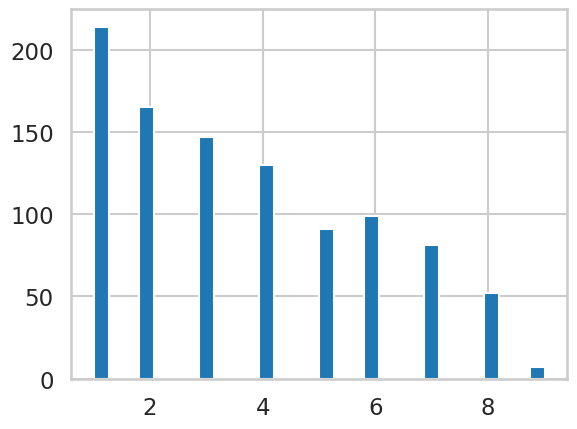

In [8]:
plt.hist(np.abs(np.diff(coords.index).astype('timedelta64[s]').astype(float)), bins=30)

### Okay, let's resample with 1 sec intevals and fill up with NaN

In [9]:
coords = step_05_resample(coords=coords, freq='1s')
coords.loc[coords.ele.isnull()].head()

,idx,lat,lon,ele,speed
time,,,,,
2023-05-28 03:34:22,NaN,NaN,NaN,NaN,NaN
2023-05-28 03:34:23,NaN,NaN,NaN,NaN,NaN
2023-05-28 03:34:24,NaN,NaN,NaN,NaN,NaN
2023-05-28 03:34:25,NaN,NaN,NaN,NaN,NaN
2023-05-28 03:34:26,NaN,NaN,NaN,NaN,NaN


(array([   0.,    0.,    0.,    0.,    0., 3600.,    0.,    0.,    0.,
           0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <BarContainer object of 10 artists>)

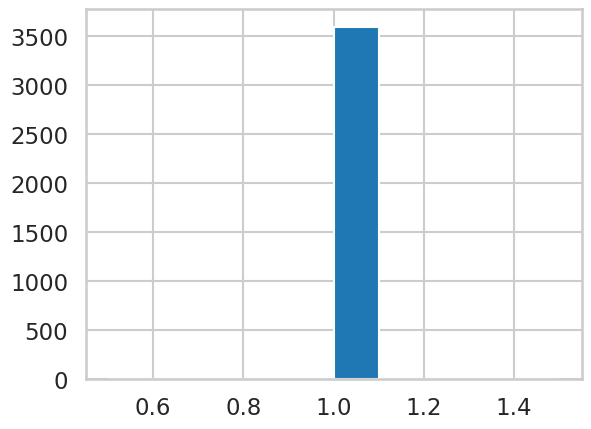

In [10]:
plt.hist(np.diff(coords.index).astype('timedelta64[s]').astype(float))

### Almost done. Now convert to good old numpy array and mask NaNs

In [11]:
measurements = step_06_get_measurements_from_coords(coords) # lon-0 lat-1 ele-2

### So where did I lose the GPS signal?

In [14]:
null_idx = np.argwhere(np.asarray(coords.ele.isnull().array)).squeeze()
coords = coords.fillna(method='pad')
filled_coords = coords.iloc[null_idx]

(array([29.025 , 29.0275, 29.03  , 29.0325, 29.035 , 29.0375, 29.04  ,
        29.0425]),
 [Text(29.025000000000002, 0, '29.0250'),
  Text(29.027500000000003, 0, '29.0275'),
  Text(29.03, 0, '29.0300'),
  Text(29.032500000000002, 0, '29.0325'),
  Text(29.035000000000004, 0, '29.0350'),
  Text(29.0375, 0, '29.0375'),
  Text(29.040000000000003, 0, '29.0400'),
  Text(29.0425, 0, '29.0425')])

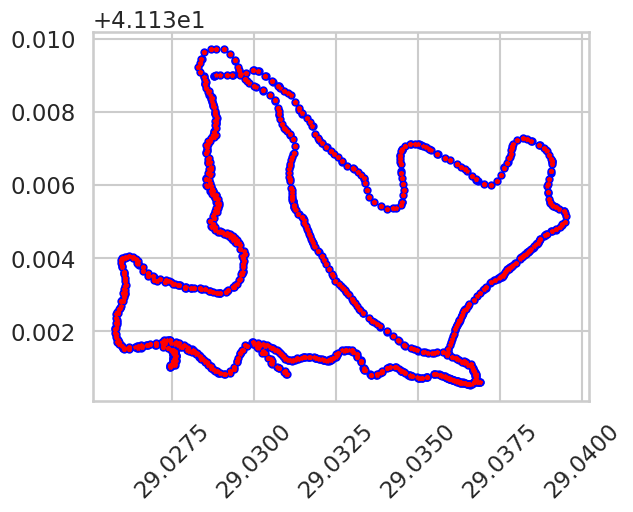

In [17]:
fig = plt.figure()
plt.plot(measurements[:,0], measurements[:,1], 'bo', markersize=5)
plt.plot(filled_coords['lon'].values, filled_coords['lat'].values, 'r*', markersize=3)
plt.xticks(rotation=45)

### Let's set up the Kalman Filter

In [ ]:
F = np.array([[1, 0, 0, 1, 0, 0],
              [0, 1, 0, 0, 1, 0],
              [0, 0, 1, 0, 0, 1],
              [0, 0, 0, 1, 0, 0],
              [0, 0, 0, 0, 1, 0],
              [0, 0, 0, 0, 0, 1]])

H = np.array([[1, 0, 0, 0, 0, 0],
              [0, 1, 0, 0, 0, 0],
              [0, 0, 1, 0, 0, 0]])

R = np.diag([1e-4, 1e-4, 100])**2

initial_state_mean = np.hstack([measurements[0, :], 3*[0.]])
# works initial_state_covariance = np.diag([1e-3, 1e-3, 100, 1e-4, 1e-4, 1e-4])**2
initial_state_covariance = np.diag([1e-4, 1e-4, 50, 1e-6, 1e-6, 1e-6])**2

In [ ]:
kf = KalmanFilter(transition_matrices=F, 
                  observation_matrices=H, 
                  observation_covariance=R,
                  initial_state_mean=initial_state_mean,
                  initial_state_covariance=initial_state_covariance,
                  em_vars=['transition_covariance'])

In [ ]:
# Careful here, expectation maximation takes several hours!
#kf = kf.em(measurements, n_iter=1000)
# or just run this instead of the one above (it is the same result)
Q = np.array([[  3.17720723e-09,  -1.56389148e-09,  -2.41793770e-07,
                 2.29258935e-09,  -3.17260647e-09,  -2.89201471e-07],
              [  1.56687815e-09,   3.16555076e-09,   1.19734906e-07,
                 3.17314157e-09,   2.27469595e-09,  -2.11189940e-08],
              [ -5.13624053e-08,   2.60171362e-07,   4.62632068e-01,
                 1.00082746e-07,   2.81568920e-07,   6.99461902e-05],
              [  2.98805710e-09,  -8.62315114e-10,  -1.90678253e-07,
                 5.58468140e-09,  -5.46272629e-09,  -5.75557899e-07],
              [  8.66285671e-10,   2.97046913e-09,   1.54584155e-07,
                 5.46269262e-09,   5.55161528e-09,   5.67122163e-08],
              [ -9.24540217e-08,   2.09822077e-07,   7.65126136e-05,
                 4.58344911e-08,   5.74790902e-07,   3.89895992e-04]])
Q = 0.5*(Q + Q.T) # assure symmetry
kf.transition_covariance = Q

### Compare now our measurements with a smoothed track

In [ ]:
state_means, state_vars = kf.smooth(measurements)

In [ ]:
plt.plot(measurements[:,2])
plt.title('Elevation measured')

In [ ]:
fig, axs = plt.subplots(3,1, figsize=(12, 12))
title_str = ["longitude","Latitude","elevation"]
for i in range(3):
    # Plot for longitude
    axs[i].plot(state_means[:, i], label="Smoothed")
    axs[i].plot(measurements[:, i], label="Measurements")
    axs[i].set_title(title_str[i])
    axs[i].legend(fontsize='small')
    axs[i].tick_params(axis='both', which='major', labelsize='small')
    plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0., loc=2, fontsize='small')
plt.tight_layout(pad=2.5)
# Move the legends to the right of the plot
plt.show()

### Let's write the smoothed data back into our dataframe and GPX file

In [ ]:
coords.iloc[:, [2,1,3]] = state_means[:,:3]
orig_coords = coords[~coords['idx'].isnull()].set_index('idx')

In [ ]:
for i, p in enumerate(segment.points):
    p.speed = None
    p.elevation = orig_coords.at[float(i),'ele']
    p.longitude = orig_coords.at[float(i),'lon']
    p.latitude = orig_coords.at[float(i),'lat']

In [ ]:
segment.get_uphill_downhill()

### Yes, that sounds much more realistic!!! Let's also check the speed

In [ ]:
segment.points[0].speed = 0.0
segment.points[-1].speed = 0.0
gpx_file.add_missing_speeds()

speed = np.array([p.speed for p in segment.points])*3.6
speed_dict['speed_1_after_kalman'] = speed
plt.plot(speed)

### Arrrggh!!! Still not good! What the heck is going on?

In [ ]:
#print(np.argsort(speed)[:-10:-1])
sdifs = speed[1:]-speed[:-1]
max_dif_at = np.argsort(-sdifs)
print(max_dif_at[:10])
print(sdifs[max_dif_at[:10]])
print(max_dif_at[1])
use_sub_arr = get_indices(max_dif_at[1], 10, 10)
print(min(use_sub_arr), max(use_sub_arr))

In [ ]:
plt.plot(measurements[use_sub_arr,0], measurements[use_sub_arr,1], 'o', alpha=0.5)

### Here we have one of the hyperspeed points, so what happens here? Points seem to stack...

In [ ]:
segment.points[min(use_sub_arr):max(use_sub_arr)] # speed is in m/s

### Looking at these numbers the sensors seems to be quite inert! Let's just eliminate unlikely points and their surroundings by using the covariance given by the Kalman filter!

In [ ]:
bad_readings = np.argsort(np.trace(state_vars[:,:2,:2], axis1=1, axis2=2))[:-20:-1]
bad_readings = np.array([idx for idx in range(measurements.shape[0]) if np.min(np.abs(bad_readings - idx)) <= 5])
measurements.mask[bad_readings, :] = True 

In [ ]:
state_means, state_vars = kf.smooth(measurements)

### Write it back our GPX file again

In [ ]:
coords.iloc[:, [2,1,3]] = state_means[:,:3]
orig_coords = coords[~coords['idx'].isnull()].set_index('idx')
for i, p in enumerate(segment.points):
    p.speed = None
    p.elevation = orig_coords.at[float(i),'ele']
    p.longitude = orig_coords.at[float(i),'lon']
    p.latitude = orig_coords.at[float(i),'lat']

In [ ]:
segment.points[0].speed = 0.0
segment.points[-1].speed = 0.0
gpx_file.add_missing_speeds()

speed = np.array([p.speed for p in segment.points])*3.6
speed_dict['speed_2_add_missing'] = speed
plt.plot(speed[1:-1])

### We are getting there! Let's take a look where the problem is...

In [ ]:
# calculate the speed directly on our array
speed = [3.6*haversine(state_means[i,1::-1], state_means[i+1,1::-1]) for i in np.arange(state_means.shape[0]-1)]
speed_dict['speed_3_after_calc'] = speed
np.argsort(speed)[:-10:-1]

In [ ]:
plt.plot(speed[min(use_sub_arr):max(use_sub_arr)], '.')

In [ ]:
plt.plot(measurements[use_sub_arr,0], measurements[use_sub_arr,1], '.')

### mmhhh.. okay, that's hard. The GPS sensor has fallen behind in a curve, followed by "normal" readings then has caught up with the actual position

In [ ]:
# we check for strong accelerations/deaccelarations
acc = np.gradient(speed)
outliers = np.argsort(np.abs(acc))[:-40:-1]
outliers

### Okay, let's just remove those points with surroundings and let Kalman do the rest

In [ ]:
outliers = np.array([idx for idx in range(measurements.shape[0]) if np.min(np.abs(outliers - idx)) <= 12])
measurements.mask[outliers] = True
state_means, state_vars = kf.smooth(measurements)

In [ ]:
# we smooth several times
for _ in range(20):
    state_means, state_vars = kf.smooth(state_means[:,:3])

In [ ]:
speed = [3.6*haversine(state_means[i,1::-1], state_means[i+1,1::-1]) for i in np.arange(state_means.shape[0]-1)]
speed_dict['speed_4_after_calc20'] = speed
plt.plot(speed)

In [ ]:
plt.plot(speed[min(use_sub_arr):max(use_sub_arr)], '.')

In [ ]:
plt.plot(state_means[use_sub_arr,0], state_means[use_sub_arr,1], 'r.',label='smoothed')
plt.plot(measurements[use_sub_arr,0], measurements[use_sub_arr,1], '.', label='measured')
plt.legend()
plt.show()

In [ ]:
coords.iloc[:, [2,1,3]] = state_means[:,:3]
orig_coords = coords[~coords['idx'].isnull()].set_index('idx')

In [ ]:
for i, p in enumerate(segment.points):
    p.speed = None
    p.elevation = orig_coords.at[float(i),'ele']
    p.longitude = orig_coords.at[float(i),'lon']
    p.latitude = orig_coords.at[float(i),'lat']

In [ ]:
segment.get_uphill_downhill()

### Finally, write everything back to the GPX file

In [ ]:
coords.iloc[:, [2,1,3]] = state_means[:,:3]
orig_coords = coords[~coords['idx'].isnull()].set_index('idx')
for i, p in enumerate(segment.points):
    p.speed = None
    p.elevation = orig_coords.at[float(i),'ele']
    p.longitude = orig_coords.at[float(i),'lon']
    p.latitude = orig_coords.at[float(i),'lat']
segment.points[0].speed = 0.0
segment.points[-1].speed = 0.0
gpx_file.add_missing_speeds()
speed = np.array([p.speed for p in segment.points])*3.6
speed_dict['speed_5_after_final'] = speed
plt.plot(speed)

In [ ]:
fig, axs = plt.subplots(figsize=(12, 6))
thickness = 15
for key, arr in speed_dict.items():
    print(f"key: {key}, len: {len(arr)}")
    plt.plot(arr[0:300], label=key, linewidth=thickness)
    thickness -= 2

plt.legend(loc='lower center', fontsize='xx-small')
plt.title("Speed Differences")
plt.show()

In [ ]:
#with open('../gpx/3-laender-giro_cleaned.gpx', 'w') as fh:
#    fh.write(gpx_file.to_xml())